In [ ]:
# CNN (Convolutional Layer) : 이미지에서 특징들을 추출해서 특징값을 input으로 하자.
# : 입력데이터로부터 특징을 추출하는 역할을 수행하는 계층

# CNN 정리 블로그
# https://excelsior-cjh.tistory.com/180



# 합성곱 공식
입력 : (4,4), 패딩 : 1 , 스트라이드 : 1, 필터 : (3,3)
출력 : (H, W)
        입력 패딩 스트라이드 필터 스트라이드
    H : ((4 + 2 * 1       - 3) / 1 )      + 1 = 4
    W : ((4 + 2 * 1       - 3) / 1 )      + 1 = 4

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
image = np.array([[[[1],[2],[3]],
         [[4],[5],[6]],
         [[7],[8],[9]]]], dtype=np.float32)
image.shape  # (1, 3, 3, 1)

(1, 3, 3, 1)

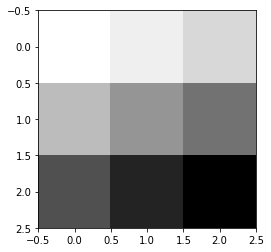

In [11]:
plt.imshow(image.reshape(3,3), cmap='Greys')

In [16]:
weight = tf.constant([[[[1.]],[[1.]]],[[[1.]],[[1.]]]])

print(weight.shape)

(2, 2, 1, 1)


In [17]:
sess = tf.InteractiveSession()

conv2d = tf.nn.conv2d(image, weight, strides=[1,1,1,1], padding='VALID')
conv2dImg = conv2d.eval()



In [19]:
conv2dImg.shape  # (1, 2, 2, 1)
conv2dImg

array([[[[12.],
         [16.]],

        [[24.],
         [28.]]]], dtype=float32)

[[12. 16.]
 [24. 28.]]


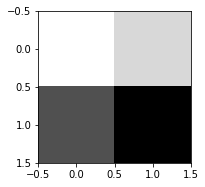

In [26]:
for i, img in enumerate(conv2dImg) :
    print(img.reshape(2,2))
    plt.subplot(1,2,i+1)
    plt.imshow(img.reshape(2,2), cmap='Greys')

In [27]:
conv2d = tf.nn.conv2d(image, weight, strides=[1,1,1,1], padding='SAME')
conv2dImg = conv2d.eval()

In [28]:
conv2dImg.shape  # (1, 2, 2, 1)
conv2dImg

array([[[[12.],
         [16.],
         [ 9.]],

        [[24.],
         [28.],
         [15.]],

        [[15.],
         [17.],
         [ 9.]]]], dtype=float32)

[[12. 16.  9.]
 [24. 28. 15.]
 [15. 17.  9.]]


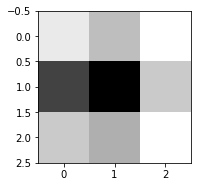

In [29]:
for i, img in enumerate(conv2dImg) :
    print(img.reshape(3,3))
    plt.subplot(1,2,i+1)
    plt.imshow(img.reshape(3,3), cmap='Greys')

In [2]:
# mnist 데이터로 CNN 모델 만들기
import random
from tensorflow.examples.tutorials.mnist import input_data

In [45]:
tf.reset_default_graph()

In [46]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [47]:
# 하이퍼 퍼러미터
lr = 0.001
epochs = 15
batch_size = 100

In [48]:
#                                입력데이터 수 x
x = tf.placeholder(tf.float32, shape=[None,28*28])
xImg = tf.reshape(x, [-1,28,28,1])
y = tf.placeholder(tf.float32, [None, 10])


In [49]:
# 입렵이미지 : shape : (?, 28, 28, 1)
# 히든 1 : weight ( w1 = 필터 )
keep_prob = tf.placeholder(tf.float32)

# 3,3 : 필터의 높이와 너비, 1: 채널의 개수, 32:필터의 개수
W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
# conv = (?, 28, 28, 32)
# relu = (?, 28, 28, 32)
# pool = (?, 14, 14 ,32)
L1 = tf.nn.conv2d(xImg, W1, strides=[1,1,1,1], padding='SAME')
L1 = tf.nn.relu(L1)
#                          커널의 크기        
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.Variable(tf.random_normal([3,3,32,64], stddev=0.01))
# conv = (?, 14, 14 ,64)
# relu = (?, 14, 14, 64)
# pool = (?, 7, 7 ,64)
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

L2_flat = tf.reshape(L2, [-1,7*7*64])

# 마지막 계층 FC 7*7*64 -> 10 output
W3 = tf.get_variable('w3', shape=[7*7*64, 10], initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))

hf = tf.matmul(L2_flat, W3) + b


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=hf , labels=y))
opt = tf.train.AdamOptimizer(lr).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 트레이닝

for epoch in range(epochs) :
    avgCost = 0
    totalBatch = int(mnist.train.num_examples / batch_size)
    for i in range(totalBatch) :
        batchX, batchY = mnist.train.next_batch(batch_size=batch_size)
        
        fd = {x:batchX, y:batchY, keep_prob:0.7}
        _, cv = sess.run([opt, cost], feed_dict=fd)
        avgCost += cv / totalBatch
    print('에폭:','%04d'%(epoch+1),'cost:','{:.5f}'.format(avgCost))
    
pred = tf.equal(tf.argmax(hf, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(pred, tf.float32))

print('accuracy : ',sess.run(acc, feed_dict = {x:mnist.test.images, y:mnist.test.labels, keep_prob:1}))

에폭: 0001 cost: 0.42547
에폭: 0002 cost: 0.13285
에폭: 0003 cost: 0.10451
에폭: 0004 cost: 0.08532
에폭: 0005 cost: 0.07368
에폭: 0006 cost: 0.06438
에폭: 0007 cost: 0.05780
에폭: 0008 cost: 0.05174
에폭: 0009 cost: 0.05008
에폭: 0010 cost: 0.04615
에폭: 0011 cost: 0.04170
에폭: 0012 cost: 0.04082
에폭: 0013 cost: 0.03766
에폭: 0014 cost: 0.03694
에폭: 0015 cost: 0.03374
accuracy :  0.9902


accuracy :  0.9895


In [ ]:
ga_ykw_01_13.jpg
da_ykw_01_13.jpg
sa_ykw_01_13.jpg
aa_ykw_01_13.jpg
ka_ykw_01_13.jpg